Connected to symdiff118 (Python 3.9.16)

In [1]:
'''
https://www.notion.so/230416-space-group-operation-loss-c6e8cbc2e93f45f69982fe5a3ccec4f1
'''
import torch
from torch_geometric.data import Batch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
import pickle as pkl

from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import *
from pymatgen.analysis.structure_matcher import StructureMatcher
from cdvae.common.data_utils import lattice_params_to_matrix_torch
from cdvae.pl_modules.space_group import *
from torch_geometric.data import Data
from torch.utils.data import Dataset
import math as m

from utils.utils_plot import vis_structure
from utils.utils_material import MatSym, MatTrans, distance_sorted, Rx, Ry, Rz, rotate_cart, switch_latvecs
from utils.plot_3d import create_animation
tol = 1e-03
import os, sys
import itertools
from pymatgen.analysis.structure_matcher import StructureMatcher
from torch.autograd.functional import jacobian

In [2]:
mpdata = pkl.load(open('data/mp_full.pkl', 'rb'))
mpids = sorted(list(mpdata.keys()))
mp_dicts = pkl.load(open('data/mp_dicts.pkl', 'rb'))

In [3]:
# cosn
cosn = mpdata['mp-20536']
silicon = mpdata['mp-149']
frac = torch.tensor(cosn.frac_coords)
lat = torch.tensor(cosn.lattice.matrix)
spec = cosn.species
natms = len(frac)

In [4]:
# test the single loss (w/o cum)
pstruct = cosn
frac = torch.tensor(pstruct.frac_coords)
frac.requires_grad = True
mt = MatTrans(pstruct)
opes = list(set(mt.spgops))
oprs = [op.rotation_matrix for op in opes]
opts = [op.translation_vector for op in opes]

r_max=0.8
sgo = torch.tensor(oprs[0])
loss_prod = sgo_loss(frac, sgo, r_max)
loss_perm = sgo_loss_perm(frac, sgo, r_max)

In [5]:
pstruct = cosn
r_max=0.8
grad=True
frac = torch.tensor(pstruct.frac_coords)#.clone().detach().requires_grad_(grad)
frac.requires_grad = grad
mt = MatTrans(pstruct)
opes = list(set(mt.spgops))
oprs = [op.rotation_matrix for op in opes]
opts = [op.translation_vector for op in opes]
oprs = [torch.tensor(opr, requires_grad=False) for opr in oprs]
frac0 = torch.tensor(pstruct.frac_coords)
frac0.requires_grad = grad
loss_prod = sgo_cum_loss(frac0, oprs, r_max)
loss_prod.backward()
print('loss_prod: ', loss_prod)
print('loss_prod.grad: ', loss_prod.grad)
print('frac0.grad: ', frac0.grad)

frac1 = torch.tensor(pstruct.frac_coords)
frac1.requires_grad = grad
loss_perm = sgo_cum_loss_perm(frac1, oprs, r_max)
loss_perm.backward()
print('loss_perm: ', loss_perm)
print('loss_perm.grad: ', loss_perm.grad)
print('frac1.grad: ', frac1.grad)

loss_prod:  tensor([0.0001], dtype=torch.float64, grad_fn=<DivBackward0>)
loss_prod.grad:  None
frac0.grad:  tensor([[-4.0939e-16,  2.7756e-17,  0.0000e+00],
        [-6.2450e-17,  7.6328e-17,  0.0000e+00],
        [-2.0817e-17,  1.1102e-16,  0.0000e+00],
        [-1.7140e+00, -2.3486e+00,  0.0000e+00],
        [ 1.7140e+00,  2.3486e+00,  0.0000e+00],
        [-1.8041e-16,  6.9389e-17,  0.0000e+00]], dtype=torch.float64)
loss_perm:  tensor([1.0999e-05], dtype=torch.float64, grad_fn=<DivBackward0>)
loss_perm.grad:  None
frac1.grad:  tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [-0.1860, -0.2550,  0.0000],
        [ 0.1860,  0.2550,  0.0000],
        [ 0.0000,  0.0000,  0.0000]], dtype=torch.float64)


<ipython-input-5-0d11db84aded>:17: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:486.)
  print('loss_prod.grad: ', loss_prod.grad)
<ipython-input-5-0d11db84aded>:25: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pyt

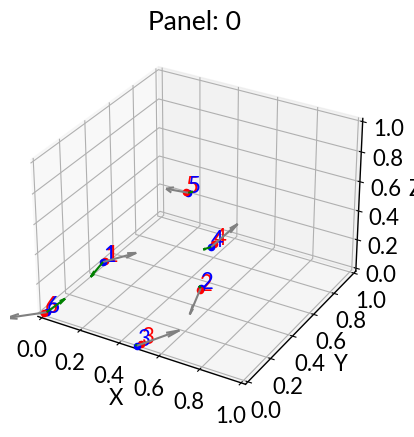

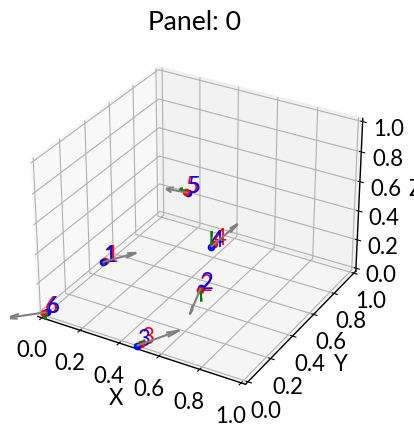

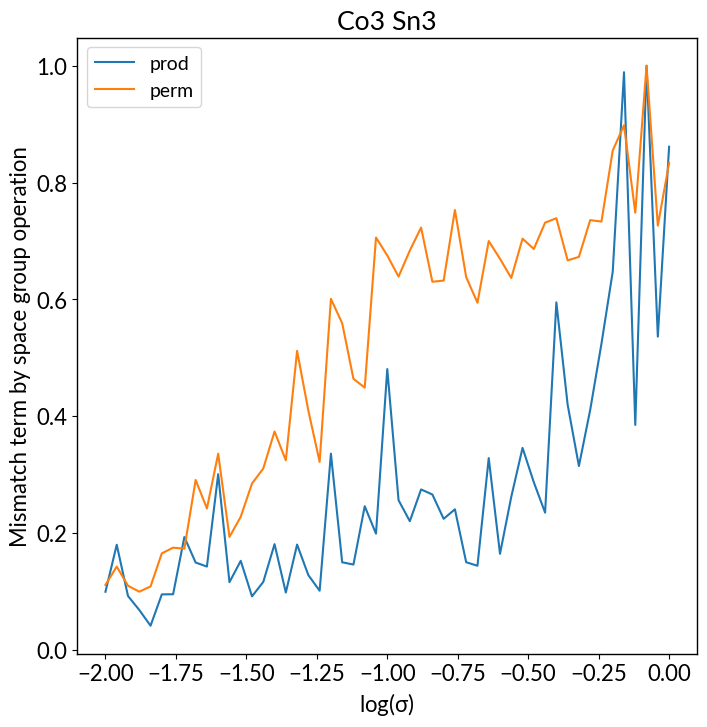

In [6]:
# with grad
# test with the diffused structures
logvars = np.linspace(-2, 0, num=51) #range(10, -5, -1)
xs = [10**l for l in logvars]
ys0 = []
ys1 = []
frac0_list = []
grads0_list = []
frac1_list = []
grads1_list = []
pstruct = cosn  #mpdata['mp-1003']#kstruct
frac_coords0 = pstruct.frac_coords  # ooriginal
mt = MatTrans(pstruct)
opes = list(set(mt.spgops))
oprs = [op.rotation_matrix for op in opes]
opts = [op.translation_vector for op in opes]
oprs = [torch.tensor(opr, requires_grad=False) for opr in oprs]
natms = len(mt.pstruct.sites)
nops = len(opes)
r_max = 0.7
h = 1e-07
tol = 1e-03
grad=True
for i, l in enumerate(logvars):
    sigma = 10**l
    dstruct = diffuse_frac(pstruct, sigma=sigma)
    # vis_structure(dstruct, title=f"$log(\sigma)$={round(l, 7)}")
    # plt.show()
    # plt.close()
    frac = torch.tensor(dstruct.frac_coords)
    frac.requires_grad = grad
    frac0, frac1 = torch.tensor(dstruct.frac_coords), torch.tensor(dstruct.frac_coords)
    frac0.requires_grad, frac1.requires_grad = grad, grad
    loss0 = sgo_cum_loss(frac0, oprs, r_max)
    ys0.append(loss0)
    loss0.backward()
    grads0 = frac0.grad
    frac0_list.append(frac0.detach().numpy())
    grads0_list.append(-grads0.detach().numpy())
    loss1 = sgo_cum_loss_perm(frac1, oprs, r_max)
    ys1.append(loss1)
    loss1.backward()
    grads1 = frac1.grad
    frac1_list.append(frac1.detach().numpy())
    grads1_list.append(-grads1.detach().numpy())
    # plot_3d_vectors(frac_coords0, frac0.detach().numpy(), -grads0.detach().numpy())
    # plot_3d_vectors(frac_coords0, frac1.detach().numpy(), -grads1.detach().numpy())
create_animation(frac_coords0, frac0_list, grads0_list, 'figures/cosn0')
create_animation(frac_coords0, frac1_list, grads1_list, 'figures/cosn1')

fig, ax = plt.subplots(1,1,figsize=(8,8))
ys0 = [y.detach().numpy() for y in ys0]
ys1 = [y.detach().numpy() for y in ys1]
ax.plot(logvars, ys0/max(ys0), label='prod')
ax.plot(logvars, ys1/max(ys1), label='perm')
ax.legend()
ax.set_ylabel(f"Mismatch term by space group operation")
ax.set_xlabel(f"$log(\sigma)$")
ax.set_title(pstruct.formula)
# ax.set_yscale('log')
fig.patch.set_facecolor('white')

In [7]:
import ot
import torch
import numpy as np

def compute_sq_dist_mat(X_1, X_2):
    '''Computes the l2 squared cost matrix between two point cloud inputs.
    Args:
        X_1: [n, #features] point cloud, tensor
        X_2: [m, #features] point cloud, tensor
    Output:
        [n, m] matrix of the l2 distance between point pairs
    '''
    n_1, _ = X_1.size()
    n_2, _ = X_2.size()
    X_1 = X_1.view(n_1, 1, -1)
    X_2 = X_2.view(1, n_2, -1)
    squared_dist = (X_1 - X_2) ** 2
    cost_mat = torch.sum(squared_dist, dim=2)
    return cost_mat


def compute_ot_emd(cost_mat, device):
    cost_mat_detach = cost_mat.detach().cpu().numpy()
    a = np.ones([cost_mat.shape[0]]) / cost_mat.shape[0]
    b = np.ones([cost_mat.shape[1]]) / cost_mat.shape[1]
    ot_mat = ot.emd(a=a, b=b, M=cost_mat_detach, numItermax=10000)
    ot_mat_attached = torch.tensor(ot_mat, device=device, requires_grad=False).float()
    ot_dist = torch.sum(ot_mat_attached * cost_mat)
    return ot_dist, ot_mat_attached

In [8]:
def sgo_loss_ot1(frac, opr, r_max=None, use_min_edges=False, num_lens=1, threshold=1e-3): # can be vectorized for multiple space group opoerations?
    """
    Space group loss: The larger this loss is, the more the structure is apart from the given space group. 
    """
    frac0 = frac.clone()#.detach()
    frac0.requires_grad_()
    frac1 = frac.clone()
    frac1.requires_grad_()
    frac1 = frac1@opr.T%1
    ot_mat = compute_sq_dist_mat(frac0, frac1)
    return compute_ot_emd(ot_mat, device='cuda:0')

def sgo_cum_loss_ot1(frac, oprs, r_max):
    """
    Cumulative loss from space group operations.
    """
    loss = torch.zeros(1).to(frac)
    # loss.requires_grad=True
    nops = len(oprs)
    for opr in oprs:
        diff = sgo_loss_ot1(frac, opr, r_max)
        loss += diff
    return loss/nops

In [9]:
# with grad
# test with the diffused structures
logvars = np.linspace(-2, 0, num=51) #range(10, -5, -1)
xs = [10**l for l in logvars]
ys0 = []
ys1 = []
ys2 = []
frac0_list = []
grads0_list = []
frac1_list = []
grads1_list = []
frac2_list = []
grads2_list = []
pstruct = cosn  #mpdata['mp-1003']#kstruct
frac_coords0 = pstruct.frac_coords  # ooriginal
mt = MatTrans(pstruct)
opes = list(set(mt.spgops))
oprs = [op.rotation_matrix for op in opes]
opts = [op.translation_vector for op in opes]
oprs = [torch.tensor(opr, requires_grad=False) for opr in oprs]
natms = len(mt.pstruct.sites)
nops = len(opes)
r_max = 0.7
h = 1e-07
tol = 1e-03
grad=True
for i, l in enumerate(logvars):
    sigma = 10**l
    dstruct = diffuse_frac(pstruct, sigma=sigma)
    # vis_structure(dstruct, title=f"$log(\sigma)$={round(l, 7)}")
    # plt.show()
    # plt.close()
    frac = torch.tensor(dstruct.frac_coords)
    frac.requires_grad = grad
    frac0, frac1, frac2 = torch.tensor(dstruct.frac_coords), torch.tensor(dstruct.frac_coords), torch.tensor(dstruct.frac_coords)
    frac0.requires_grad, frac1.requires_grad = grad, grad
    loss0 = sgo_cum_loss(frac0, oprs, r_max)
    ys0.append(loss0)
    loss0.backward()
    grads0 = frac0.grad
    frac0_list.append(frac0.detach().numpy())
    grads0_list.append(-grads0.detach().numpy())
    loss1 = sgo_cum_loss_perm(frac1, oprs, r_max)
    ys1.append(loss1)
    loss1.backward()
    grads1 = frac1.grad
    frac1_list.append(frac1.detach().numpy())
    grads1_list.append(-grads1.detach().numpy())
    loss2 = sgo_cum_loss_ot1(frac2, oprs, r_max)
    ys1.append(loss2)
    loss2.backward()
    grads2 = frac2.grad
    frac2_list.append(frac2.detach().numpy())
    grads2_list.append(-grads2.detach().numpy())
    # plot_3d_vectors(frac_coords0, frac0.detach().numpy(), -grads0.detach().numpy())
    # plot_3d_vectors(frac_coords0, frac1.detach().numpy(), -grads1.detach().numpy())
create_animation(frac_coords0, frac0_list, grads0_list, 'figures/cosn0')
create_animation(frac_coords0, frac1_list, grads1_list, 'figures/cosn1')

fig, ax = plt.subplots(1,1,figsize=(8,8))
ys0 = [y.detach().numpy() for y in ys0]
ys1 = [y.detach().numpy() for y in ys1]
ys2 = [y.detach().numpy() for y in ys2]
ax.plot(logvars, ys0/max(ys0), label='prod')
ax.plot(logvars, ys1/max(ys1), label='perm')
ax.plot(logvars, ys2/max(ys2), label='ot1')
ax.legend()
ax.set_ylabel(f"Mismatch term by space group operation")
ax.set_xlabel(f"$log(\sigma)$")
ax.set_title(pstruct.formula)
# ax.set_yscale('log')
fig.patch.set_facecolor('white')


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [10]:
def sgo_loss_ot1(frac, opr, r_max=None, use_min_edges=False, num_lens=1, threshold=1e-3): # can be vectorized for multiple space group opoerations?
    """
    Space group loss: The larger this loss is, the more the structure is apart from the given space group. 
    """
    frac0 = frac.clone()#.detach()
    frac0.requires_grad_()
    frac1 = frac.clone()
    frac1.requires_grad_()
    frac1 = frac1@opr.T%1
    ot_mat = compute_sq_dist_mat(frac0, frac1)
    return compute_ot_emd(ot_mat, device='cpu')

def sgo_cum_loss_ot1(frac, oprs, r_max):
    """
    Cumulative loss from space group operations.
    """
    loss = torch.zeros(1).to(frac)
    # loss.requires_grad=True
    nops = len(oprs)
    for opr in oprs:
        diff = sgo_loss_ot1(frac, opr, r_max)
        loss += diff
    return loss/nops

In [11]:
# with grad
# test with the diffused structures
logvars = np.linspace(-2, 0, num=51) #range(10, -5, -1)
xs = [10**l for l in logvars]
ys0 = []
ys1 = []
ys2 = []
frac0_list = []
grads0_list = []
frac1_list = []
grads1_list = []
frac2_list = []
grads2_list = []
pstruct = cosn  #mpdata['mp-1003']#kstruct
frac_coords0 = pstruct.frac_coords  # ooriginal
mt = MatTrans(pstruct)
opes = list(set(mt.spgops))
oprs = [op.rotation_matrix for op in opes]
opts = [op.translation_vector for op in opes]
oprs = [torch.tensor(opr, requires_grad=False) for opr in oprs]
natms = len(mt.pstruct.sites)
nops = len(opes)
r_max = 0.7
h = 1e-07
tol = 1e-03
grad=True
for i, l in enumerate(logvars):
    sigma = 10**l
    dstruct = diffuse_frac(pstruct, sigma=sigma)
    # vis_structure(dstruct, title=f"$log(\sigma)$={round(l, 7)}")
    # plt.show()
    # plt.close()
    frac = torch.tensor(dstruct.frac_coords)
    frac.requires_grad = grad
    frac0, frac1, frac2 = torch.tensor(dstruct.frac_coords), torch.tensor(dstruct.frac_coords), torch.tensor(dstruct.frac_coords)
    frac0.requires_grad, frac1.requires_grad = grad, grad
    loss0 = sgo_cum_loss(frac0, oprs, r_max)
    ys0.append(loss0)
    loss0.backward()
    grads0 = frac0.grad
    frac0_list.append(frac0.detach().numpy())
    grads0_list.append(-grads0.detach().numpy())
    loss1 = sgo_cum_loss_perm(frac1, oprs, r_max)
    ys1.append(loss1)
    loss1.backward()
    grads1 = frac1.grad
    frac1_list.append(frac1.detach().numpy())
    grads1_list.append(-grads1.detach().numpy())
    loss2 = sgo_cum_loss_ot1(frac2, oprs, r_max)
    ys1.append(loss2)
    loss2.backward()
    grads2 = frac2.grad
    frac2_list.append(frac2.detach().numpy())
    grads2_list.append(-grads2.detach().numpy())
    # plot_3d_vectors(frac_coords0, frac0.detach().numpy(), -grads0.detach().numpy())
    # plot_3d_vectors(frac_coords0, frac1.detach().numpy(), -grads1.detach().numpy())
create_animation(frac_coords0, frac0_list, grads0_list, 'figures/cosn0')
create_animation(frac_coords0, frac1_list, grads1_list, 'figures/cosn1')

fig, ax = plt.subplots(1,1,figsize=(8,8))
ys0 = [y.detach().numpy() for y in ys0]
ys1 = [y.detach().numpy() for y in ys1]
ys2 = [y.detach().numpy() for y in ys2]
ax.plot(logvars, ys0/max(ys0), label='prod')
ax.plot(logvars, ys1/max(ys1), label='perm')
ax.plot(logvars, ys2/max(ys2), label='ot1')
ax.legend()
ax.set_ylabel(f"Mismatch term by space group operation")
ax.set_xlabel(f"$log(\sigma)$")
ax.set_title(pstruct.formula)
# ax.set_yscale('log')
fig.patch.set_facecolor('white')


TypeError: unsupported operand type(s) for +=: 'Tensor' and 'tuple'

In [12]:
def sgo_loss_ot1(frac, opr, r_max=None, use_min_edges=False, num_lens=1, threshold=1e-3): # can be vectorized for multiple space group opoerations?
    """
    Space group loss: The larger this loss is, the more the structure is apart from the given space group. 
    """
    frac0 = frac.clone()#.detach()
    frac0.requires_grad_()
    frac1 = frac.clone()
    frac1.requires_grad_()
    frac1 = frac1@opr.T%1
    ot_mat = compute_sq_dist_mat(frac0, frac1)
    return compute_ot_emd(ot_mat, device='cpu')[0]

def sgo_cum_loss_ot1(frac, oprs, r_max):
    """
    Cumulative loss from space group operations.
    """
    loss = torch.zeros(1).to(frac)
    # loss.requires_grad=True
    nops = len(oprs)
    for opr in oprs:
        diff = sgo_loss_ot1(frac, opr, r_max)
        loss += diff
    return loss/nops

In [13]:
# with grad
# test with the diffused structures
logvars = np.linspace(-2, 0, num=51) #range(10, -5, -1)
xs = [10**l for l in logvars]
ys0 = []
ys1 = []
ys2 = []
frac0_list = []
grads0_list = []
frac1_list = []
grads1_list = []
frac2_list = []
grads2_list = []
pstruct = cosn  #mpdata['mp-1003']#kstruct
frac_coords0 = pstruct.frac_coords  # ooriginal
mt = MatTrans(pstruct)
opes = list(set(mt.spgops))
oprs = [op.rotation_matrix for op in opes]
opts = [op.translation_vector for op in opes]
oprs = [torch.tensor(opr, requires_grad=False) for opr in oprs]
natms = len(mt.pstruct.sites)
nops = len(opes)
r_max = 0.7
h = 1e-07
tol = 1e-03
grad=True
for i, l in enumerate(logvars):
    sigma = 10**l
    dstruct = diffuse_frac(pstruct, sigma=sigma)
    # vis_structure(dstruct, title=f"$log(\sigma)$={round(l, 7)}")
    # plt.show()
    # plt.close()
    frac = torch.tensor(dstruct.frac_coords)
    frac.requires_grad = grad
    frac0, frac1, frac2 = torch.tensor(dstruct.frac_coords), torch.tensor(dstruct.frac_coords), torch.tensor(dstruct.frac_coords)
    frac0.requires_grad, frac1.requires_grad = grad, grad
    loss0 = sgo_cum_loss(frac0, oprs, r_max)
    ys0.append(loss0)
    loss0.backward()
    grads0 = frac0.grad
    frac0_list.append(frac0.detach().numpy())
    grads0_list.append(-grads0.detach().numpy())
    loss1 = sgo_cum_loss_perm(frac1, oprs, r_max)
    ys1.append(loss1)
    loss1.backward()
    grads1 = frac1.grad
    frac1_list.append(frac1.detach().numpy())
    grads1_list.append(-grads1.detach().numpy())
    loss2 = sgo_cum_loss_ot1(frac2, oprs, r_max)
    ys1.append(loss2)
    loss2.backward()
    grads2 = frac2.grad
    frac2_list.append(frac2.detach().numpy())
    grads2_list.append(-grads2.detach().numpy())
    # plot_3d_vectors(frac_coords0, frac0.detach().numpy(), -grads0.detach().numpy())
    # plot_3d_vectors(frac_coords0, frac1.detach().numpy(), -grads1.detach().numpy())
create_animation(frac_coords0, frac0_list, grads0_list, 'figures/cosn0')
create_animation(frac_coords0, frac1_list, grads1_list, 'figures/cosn1')

fig, ax = plt.subplots(1,1,figsize=(8,8))
ys0 = [y.detach().numpy() for y in ys0]
ys1 = [y.detach().numpy() for y in ys1]
ys2 = [y.detach().numpy() for y in ys2]
ax.plot(logvars, ys0/max(ys0), label='prod')
ax.plot(logvars, ys1/max(ys1), label='perm')
ax.plot(logvars, ys2/max(ys2), label='ot1')
ax.legend()
ax.set_ylabel(f"Mismatch term by space group operation")
ax.set_xlabel(f"$log(\sigma)$")
ax.set_title(pstruct.formula)
# ax.set_yscale('log')
fig.patch.set_facecolor('white')


AttributeError: 'NoneType' object has no attribute 'detach'

In [14]:
loss2

tensor([0.3532], dtype=torch.float64, grad_fn=<DivBackward0>)

In [15]:
loss1

tensor([0.0335], dtype=torch.float64, grad_fn=<DivBackward0>)

In [16]:
grads2

In [17]:
grads1

tensor([[-0.2817,  0.1815, -0.0991],
        [-0.0752,  0.1174, -0.2226],
        [ 0.1021, -0.0737,  0.0921],
        [ 0.2474, -0.2809, -0.0706],
        [-0.0228,  0.0605,  0.1583],
        [ 0.0303, -0.0047,  0.1419]], dtype=torch.float64)

In [18]:
grads0

tensor([[-4.8465e-01, -1.8465e-02, -6.4185e-17],
        [ 4.5002e-01, -1.4786e+00,  1.3878e-17],
        [ 9.1325e-01, -7.3537e-01, -5.5086e-04],
        [-7.1667e-01,  1.2375e+00, -2.8796e-16],
        [ 1.0756e-01, -6.5823e-01,  9.4958e-01],
        [-2.6951e-01,  1.6532e+00, -9.4903e-01]], dtype=torch.float64)

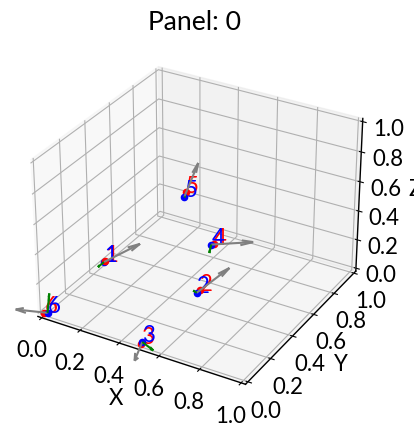

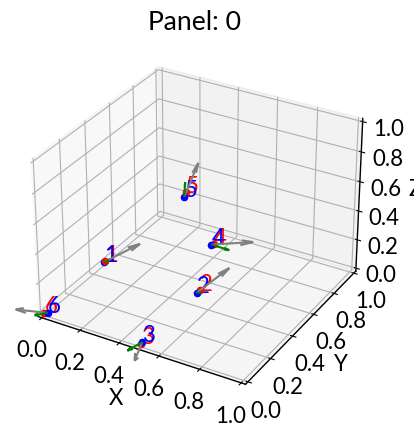

ValueError: x and y must have same first dimension, but have shapes (51,) and (102, 1)

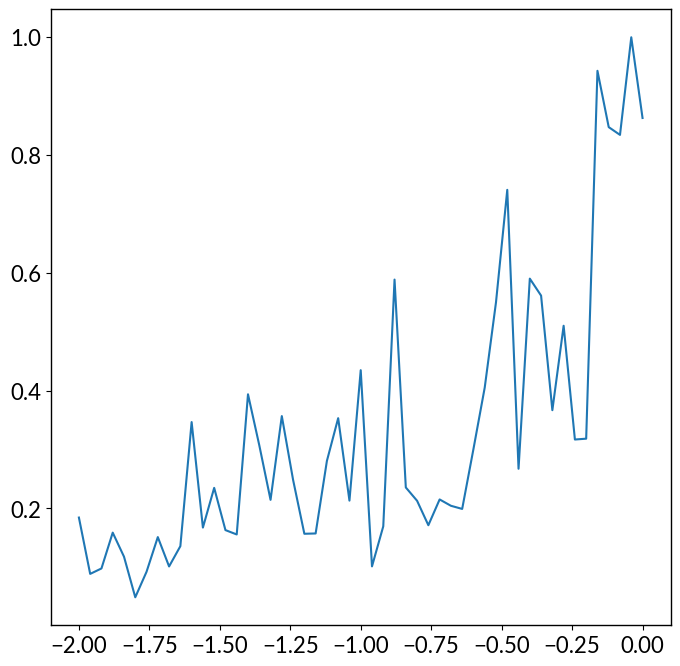

In [19]:
# with grad
# test with the diffused structures
logvars = np.linspace(-2, 0, num=51) #range(10, -5, -1)
xs = [10**l for l in logvars]
ys0 = []
ys1 = []
ys2 = []
frac0_list = []
grads0_list = []
frac1_list = []
grads1_list = []
frac2_list = []
grads2_list = []
pstruct = cosn  #mpdata['mp-1003']#kstruct
frac_coords0 = pstruct.frac_coords  # ooriginal
mt = MatTrans(pstruct)
opes = list(set(mt.spgops))
oprs = [op.rotation_matrix for op in opes]
opts = [op.translation_vector for op in opes]
oprs = [torch.tensor(opr, requires_grad=False) for opr in oprs]
natms = len(mt.pstruct.sites)
nops = len(opes)
r_max = 0.7
h = 1e-07
tol = 1e-03
grad=True
for i, l in enumerate(logvars):
    sigma = 10**l
    dstruct = diffuse_frac(pstruct, sigma=sigma)
    # vis_structure(dstruct, title=f"$log(\sigma)$={round(l, 7)}")
    # plt.show()
    # plt.close()
    frac = torch.tensor(dstruct.frac_coords)
    frac.requires_grad = grad
    frac0, frac1, frac2 = torch.tensor(dstruct.frac_coords), torch.tensor(dstruct.frac_coords), torch.tensor(dstruct.frac_coords)
    frac0.requires_grad, frac1.requires_grad = grad, grad
    loss0 = sgo_cum_loss(frac0, oprs, r_max)
    ys0.append(loss0)
    loss0.backward()
    grads0 = frac0.grad
    frac0_list.append(frac0.detach().numpy())
    grads0_list.append(-grads0.detach().numpy())
    loss1 = sgo_cum_loss_perm(frac1, oprs, r_max)
    ys1.append(loss1)
    loss1.backward()
    grads1 = frac1.grad
    frac1_list.append(frac1.detach().numpy())
    grads1_list.append(-grads1.detach().numpy())
    loss2 = sgo_cum_loss_ot1(frac2, oprs, r_max)
    ys1.append(loss2)
    loss2.backward()
    grads2 = frac2.grad
    frac2_list.append(frac2.detach().numpy())
    # grads2_list.append(-grads2.detach().numpy())
    # plot_3d_vectors(frac_coords0, frac0.detach().numpy(), -grads0.detach().numpy())
    # plot_3d_vectors(frac_coords0, frac1.detach().numpy(), -grads1.detach().numpy())
create_animation(frac_coords0, frac0_list, grads0_list, 'figures/cosn0')
create_animation(frac_coords0, frac1_list, grads1_list, 'figures/cosn1')

fig, ax = plt.subplots(1,1,figsize=(8,8))
ys0 = [y.detach().numpy() for y in ys0]
ys1 = [y.detach().numpy() for y in ys1]
ys2 = [y.detach().numpy() for y in ys2]
ax.plot(logvars, ys0/max(ys0), label='prod')
ax.plot(logvars, ys1/max(ys1), label='perm')
ax.plot(logvars, ys2/max(ys2), label='ot1')
ax.legend()
ax.set_ylabel(f"Mismatch term by space group operation")
ax.set_xlabel(f"$log(\sigma)$")
ax.set_title(pstruct.formula)
# ax.set_yscale('log')
fig.patch.set_facecolor('white')


In [20]:
logvars

array([-2.  , -1.96, -1.92, -1.88, -1.84, -1.8 , -1.76, -1.72, -1.68,
       -1.64, -1.6 , -1.56, -1.52, -1.48, -1.44, -1.4 , -1.36, -1.32,
       -1.28, -1.24, -1.2 , -1.16, -1.12, -1.08, -1.04, -1.  , -0.96,
       -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68, -0.64, -0.6 ,
       -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32, -0.28, -0.24,
       -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ])

In [21]:
logvars.shape

(51,)

In [22]:
ys1.sape

AttributeError: 'list' object has no attribute 'sape'

In [23]:
len(ys1)

102

In [24]:
len(ys0)

51

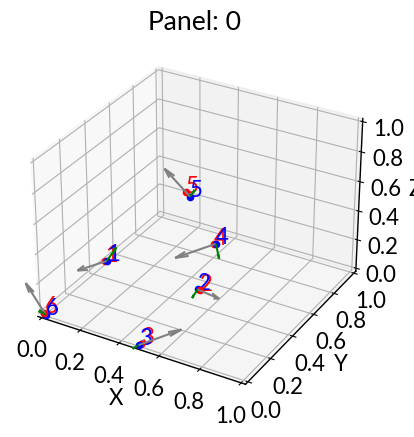

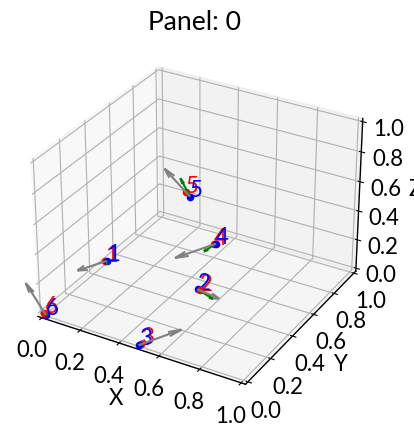

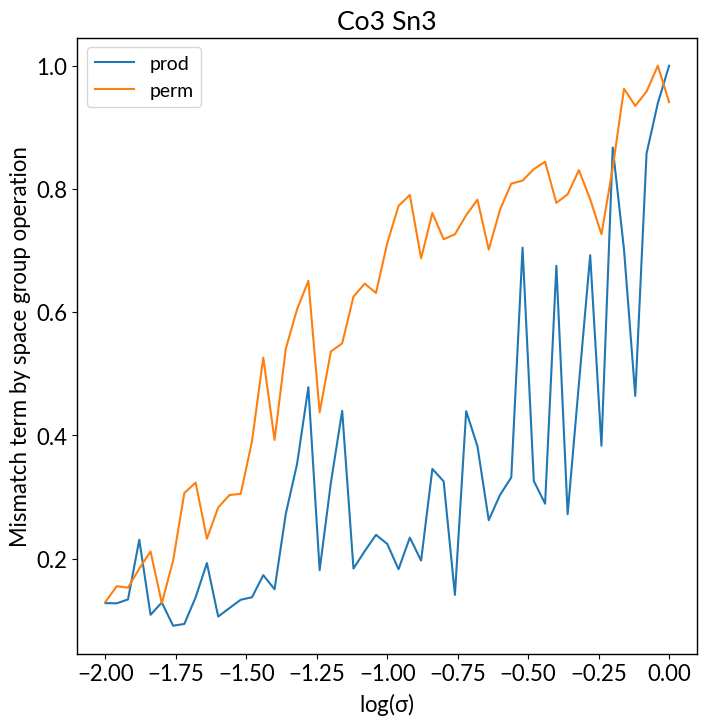

In [25]:
# with grad
# test with the diffused structures
logvars = np.linspace(-2, 0, num=51) #range(10, -5, -1)
xs = [10**l for l in logvars]
ys0 = []
ys1 = []
frac0_list = []
grads0_list = []
frac1_list = []
grads1_list = []
pstruct = cosn  #mpdata['mp-1003']#kstruct
frac_coords0 = pstruct.frac_coords  # ooriginal
mt = MatTrans(pstruct)
opes = list(set(mt.spgops))
oprs = [op.rotation_matrix for op in opes]
opts = [op.translation_vector for op in opes]
oprs = [torch.tensor(opr, requires_grad=False) for opr in oprs]
natms = len(mt.pstruct.sites)
nops = len(opes)
r_max = 0.7
h = 1e-07
tol = 1e-03
grad=True
for i, l in enumerate(logvars):
    sigma = 10**l
    dstruct = diffuse_frac(pstruct, sigma=sigma)
    # vis_structure(dstruct, title=f"$log(\sigma)$={round(l, 7)}")
    # plt.show()
    # plt.close()
    frac = torch.tensor(dstruct.frac_coords)
    frac.requires_grad = grad
    frac0, frac1 = torch.tensor(dstruct.frac_coords), torch.tensor(dstruct.frac_coords)
    frac0.requires_grad, frac1.requires_grad = grad, grad
    loss0 = sgo_cum_loss(frac0, oprs, r_max)
    ys0.append(loss0)
    loss0.backward()
    grads0 = frac0.grad
    frac0_list.append(frac0.detach().numpy())
    grads0_list.append(-grads0.detach().numpy())
    loss1 = sgo_cum_loss_perm(frac1, oprs, r_max)
    ys1.append(loss1)
    loss1.backward()
    grads1 = frac1.grad
    frac1_list.append(frac1.detach().numpy())
    grads1_list.append(-grads1.detach().numpy())
    # plot_3d_vectors(frac_coords0, frac0.detach().numpy(), -grads0.detach().numpy())
    # plot_3d_vectors(frac_coords0, frac1.detach().numpy(), -grads1.detach().numpy())
create_animation(frac_coords0, frac0_list, grads0_list, 'figures/cosn0')
create_animation(frac_coords0, frac1_list, grads1_list, 'figures/cosn1')

fig, ax = plt.subplots(1,1,figsize=(8,8))
ys0 = [y.detach().numpy() for y in ys0]
ys1 = [y.detach().numpy() for y in ys1]
ax.plot(logvars, ys0/max(ys0), label='prod')
ax.plot(logvars, ys1/max(ys1), label='perm')
ax.legend()
ax.set_ylabel(f"Mismatch term by space group operation")
ax.set_xlabel(f"$log(\sigma)$")
ax.set_title(pstruct.formula)
# ax.set_yscale('log')
fig.patch.set_facecolor('white')


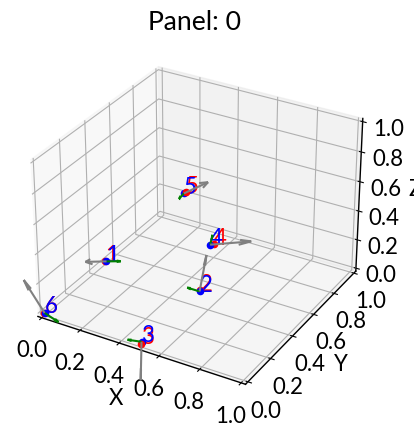

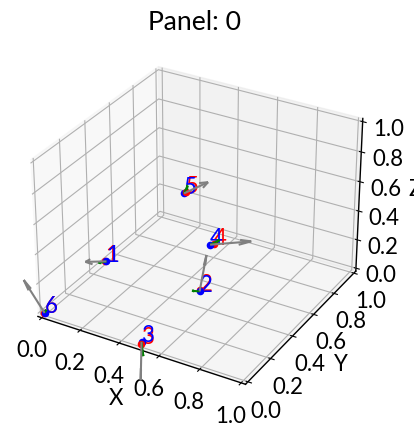

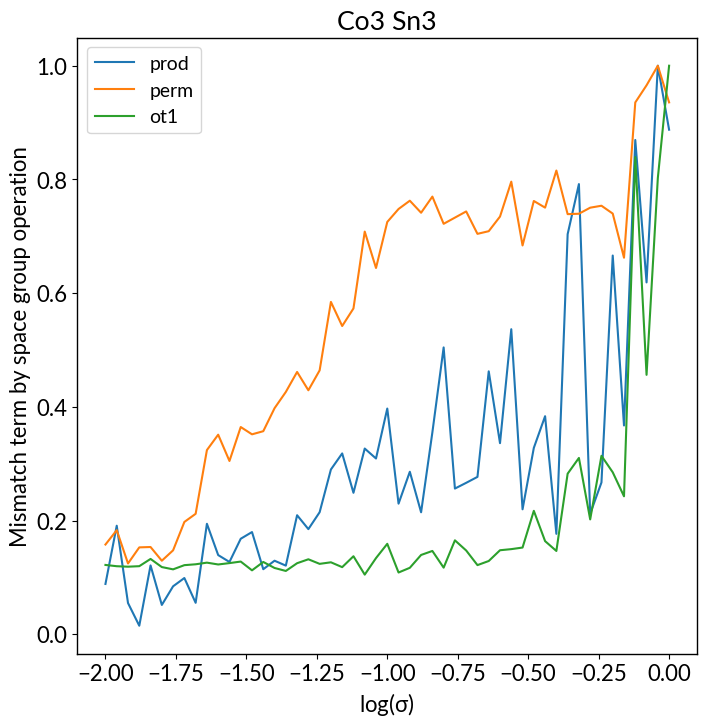

In [26]:
# with grad
# test with the diffused structures
logvars = np.linspace(-2, 0, num=51) #range(10, -5, -1)
xs = [10**l for l in logvars]
ys0 = []
ys1 = []
ys2 = []
frac0_list = []
grads0_list = []
frac1_list = []
grads1_list = []
frac2_list = []
grads2_list = []
pstruct = cosn  #mpdata['mp-1003']#kstruct
frac_coords0 = pstruct.frac_coords  # ooriginal
mt = MatTrans(pstruct)
opes = list(set(mt.spgops))
oprs = [op.rotation_matrix for op in opes]
opts = [op.translation_vector for op in opes]
oprs = [torch.tensor(opr, requires_grad=False) for opr in oprs]
natms = len(mt.pstruct.sites)
nops = len(opes)
r_max = 0.7
h = 1e-07
tol = 1e-03
grad=True
for i, l in enumerate(logvars):
    sigma = 10**l
    dstruct = diffuse_frac(pstruct, sigma=sigma)
    # vis_structure(dstruct, title=f"$log(\sigma)$={round(l, 7)}")
    # plt.show()
    # plt.close()
    frac = torch.tensor(dstruct.frac_coords)
    frac.requires_grad = grad
    frac0, frac1, frac2 = torch.tensor(dstruct.frac_coords), torch.tensor(dstruct.frac_coords), torch.tensor(dstruct.frac_coords)
    frac0.requires_grad, frac1.requires_grad = grad, grad
    loss0 = sgo_cum_loss(frac0, oprs, r_max)
    ys0.append(loss0)
    loss0.backward()
    grads0 = frac0.grad
    frac0_list.append(frac0.detach().numpy())
    grads0_list.append(-grads0.detach().numpy())
    loss1 = sgo_cum_loss_perm(frac1, oprs, r_max)
    ys1.append(loss1)
    loss1.backward()
    grads1 = frac1.grad
    frac1_list.append(frac1.detach().numpy())
    grads1_list.append(-grads1.detach().numpy())
    loss2 = sgo_cum_loss_ot1(frac2, oprs, r_max)
    ys2.append(loss2)
    loss2.backward()
    grads2 = frac2.grad
    frac2_list.append(frac2.detach().numpy())
    # grads2_list.append(-grads2.detach().numpy())
    # plot_3d_vectors(frac_coords0, frac0.detach().numpy(), -grads0.detach().numpy())
    # plot_3d_vectors(frac_coords0, frac1.detach().numpy(), -grads1.detach().numpy())
create_animation(frac_coords0, frac0_list, grads0_list, 'figures/cosn0')
create_animation(frac_coords0, frac1_list, grads1_list, 'figures/cosn1')

fig, ax = plt.subplots(1,1,figsize=(8,8))
ys0 = [y.detach().numpy() for y in ys0]
ys1 = [y.detach().numpy() for y in ys1]
ys2 = [y.detach().numpy() for y in ys2]
ax.plot(logvars, ys0/max(ys0), label='prod')
ax.plot(logvars, ys1/max(ys1), label='perm')
ax.plot(logvars, ys2/max(ys2), label='ot1')
ax.legend()
ax.set_ylabel(f"Mismatch term by space group operation")
ax.set_xlabel(f"$log(\sigma)$")
ax.set_title(pstruct.formula)
# ax.set_yscale('log')
fig.patch.set_facecolor('white')


In [27]:
def sgo_loss_ot2(frac, opr, r_max): # can be vectorized for multiple space group opoerations?
    """
    Space group loss: The larger this loss is, the more the structure is apart from the given space group. 
    """
    frac0 = frac.clone()#.detach()
    frac0.requires_grad_()
    frac1 = frac.clone()
    frac1.requires_grad_()
    frac1 = frac1@opr.T%1
    _, _, edge_vec0 = get_neighbors(frac0, r_max)
    _, _, edge_vec1 = get_neighbors(frac1, r_max)
    ot_mat = compute_sq_dist_mat(edge_vec0, edge_vec1)
    return compute_ot_emd(ot_mat, device='cpu')

def sgo_cum_loss_ot2(frac, oprs, r_max):
    """
    Cumulative loss from space group operations.
    """
    loss = torch.zeros(1).to(frac)
    # loss.requires_grad=True
    nops = len(oprs)
    for opr in oprs:
        diff = sgo_loss_ot2(frac, opr, r_max)
        loss += diff
    return loss/nops

In [28]:
# with grad
# test with the diffused structures
logvars = np.linspace(-2, 0, num=51) #range(10, -5, -1)
xs = [10**l for l in logvars]
ys0 = []
ys1 = []
ys2 = []
frac0_list = []
grads0_list = []
frac1_list = []
grads1_list = []
frac2_list = []
grads2_list = []
pstruct = cosn  #mpdata['mp-1003']#kstruct
frac_coords0 = pstruct.frac_coords  # ooriginal
mt = MatTrans(pstruct)
opes = list(set(mt.spgops))
oprs = [op.rotation_matrix for op in opes]
opts = [op.translation_vector for op in opes]
oprs = [torch.tensor(opr, requires_grad=False) for opr in oprs]
natms = len(mt.pstruct.sites)
nops = len(opes)
r_max = 0.7
h = 1e-07
tol = 1e-03
grad=True
for i, l in enumerate(logvars):
    sigma = 10**l
    dstruct = diffuse_frac(pstruct, sigma=sigma)
    # vis_structure(dstruct, title=f"$log(\sigma)$={round(l, 7)}")
    # plt.show()
    # plt.close()
    frac = torch.tensor(dstruct.frac_coords)
    frac.requires_grad = grad
    frac0, frac1, frac2 = torch.tensor(dstruct.frac_coords), torch.tensor(dstruct.frac_coords), torch.tensor(dstruct.frac_coords)
    frac0.requires_grad, frac1.requires_grad = grad, grad
    loss0 = sgo_cum_loss(frac0, oprs, r_max)
    ys0.append(loss0)
    loss0.backward()
    grads0 = frac0.grad
    frac0_list.append(frac0.detach().numpy())
    grads0_list.append(-grads0.detach().numpy())
    loss1 = sgo_cum_loss_perm(frac1, oprs, r_max)
    ys1.append(loss1)
    loss1.backward()
    grads1 = frac1.grad
    frac1_list.append(frac1.detach().numpy())
    grads1_list.append(-grads1.detach().numpy())
    loss2 = sgo_cum_loss_ot2(frac2, oprs, r_max)
    ys2.append(loss2)
    loss2.backward()
    grads2 = frac2.grad
    frac2_list.append(frac2.detach().numpy())
    # grads2_list.append(-grads2.detach().numpy())
    # plot_3d_vectors(frac_coords0, frac0.detach().numpy(), -grads0.detach().numpy())
    # plot_3d_vectors(frac_coords0, frac1.detach().numpy(), -grads1.detach().numpy())
create_animation(frac_coords0, frac0_list, grads0_list, 'figures/cosn0')
create_animation(frac_coords0, frac1_list, grads1_list, 'figures/cosn1')

fig, ax = plt.subplots(1,1,figsize=(8,8))
ys0 = [y.detach().numpy() for y in ys0]
ys1 = [y.detach().numpy() for y in ys1]
ys2 = [y.detach().numpy() for y in ys2]
ax.plot(logvars, ys0/max(ys0), label='prod')
ax.plot(logvars, ys1/max(ys1), label='perm')
ax.plot(logvars, ys2/max(ys2), label='ot2')
ax.legend()
ax.set_ylabel(f"Mismatch term by space group operation")
ax.set_xlabel(f"$log(\sigma)$")
ax.set_title(pstruct.formula)
# ax.set_yscale('log')
fig.patch.set_facecolor('white')


TypeError: unsupported operand type(s) for +=: 'Tensor' and 'tuple'

In [29]:
def sgo_loss_ot2(frac, opr, r_max): # can be vectorized for multiple space group opoerations?
    """
    Space group loss: The larger this loss is, the more the structure is apart from the given space group. 
    """
    frac0 = frac.clone()#.detach()
    frac0.requires_grad_()
    frac1 = frac.clone()
    frac1.requires_grad_()
    frac1 = frac1@opr.T%1
    _, _, edge_vec0 = get_neighbors(frac0, r_max)
    _, _, edge_vec1 = get_neighbors(frac1, r_max)
    ot_mat = compute_sq_dist_mat(edge_vec0, edge_vec1)
    return compute_ot_emd(ot_mat, device='cpu')[0]

def sgo_cum_loss_ot2(frac, oprs, r_max):
    """
    Cumulative loss from space group operations.
    """
    loss = torch.zeros(1).to(frac)
    # loss.requires_grad=True
    nops = len(oprs)
    for opr in oprs:
        diff = sgo_loss_ot2(frac, opr, r_max)
        loss += diff
    return loss/nops

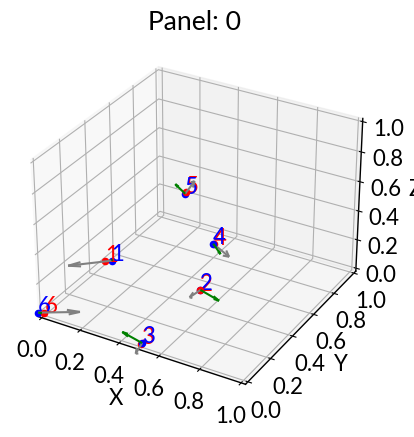

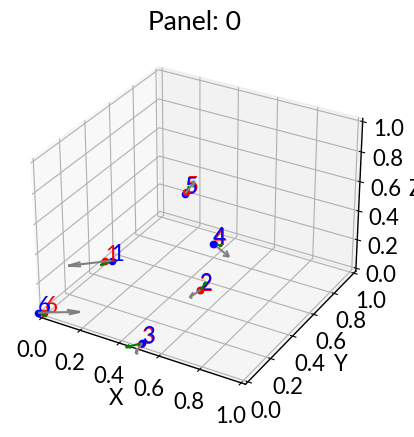

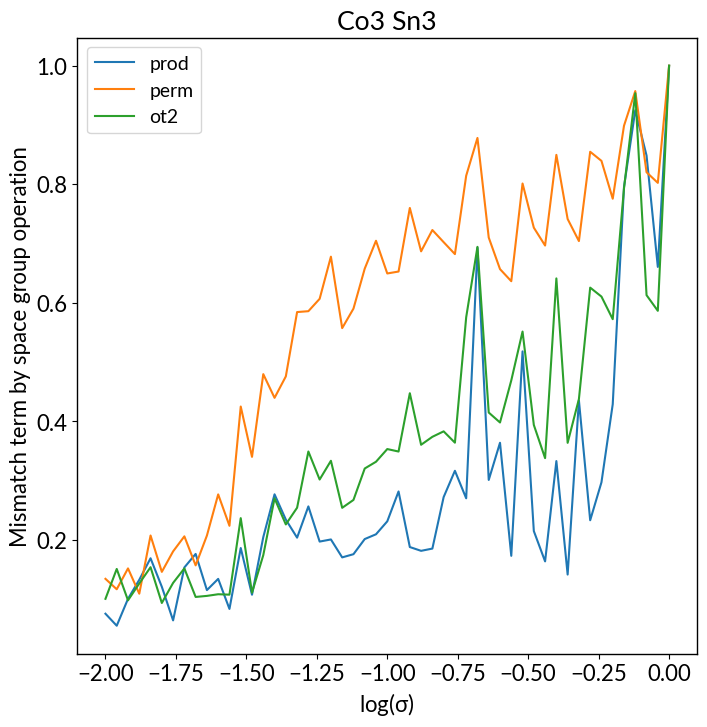

In [30]:
# with grad
# test with the diffused structures
logvars = np.linspace(-2, 0, num=51) #range(10, -5, -1)
xs = [10**l for l in logvars]
ys0 = []
ys1 = []
ys2 = []
frac0_list = []
grads0_list = []
frac1_list = []
grads1_list = []
frac2_list = []
grads2_list = []
pstruct = cosn  #mpdata['mp-1003']#kstruct
frac_coords0 = pstruct.frac_coords  # ooriginal
mt = MatTrans(pstruct)
opes = list(set(mt.spgops))
oprs = [op.rotation_matrix for op in opes]
opts = [op.translation_vector for op in opes]
oprs = [torch.tensor(opr, requires_grad=False) for opr in oprs]
natms = len(mt.pstruct.sites)
nops = len(opes)
r_max = 0.7
h = 1e-07
tol = 1e-03
grad=True
for i, l in enumerate(logvars):
    sigma = 10**l
    dstruct = diffuse_frac(pstruct, sigma=sigma)
    # vis_structure(dstruct, title=f"$log(\sigma)$={round(l, 7)}")
    # plt.show()
    # plt.close()
    frac = torch.tensor(dstruct.frac_coords)
    frac.requires_grad = grad
    frac0, frac1, frac2 = torch.tensor(dstruct.frac_coords), torch.tensor(dstruct.frac_coords), torch.tensor(dstruct.frac_coords)
    frac0.requires_grad, frac1.requires_grad = grad, grad
    loss0 = sgo_cum_loss(frac0, oprs, r_max)
    ys0.append(loss0)
    loss0.backward()
    grads0 = frac0.grad
    frac0_list.append(frac0.detach().numpy())
    grads0_list.append(-grads0.detach().numpy())
    loss1 = sgo_cum_loss_perm(frac1, oprs, r_max)
    ys1.append(loss1)
    loss1.backward()
    grads1 = frac1.grad
    frac1_list.append(frac1.detach().numpy())
    grads1_list.append(-grads1.detach().numpy())
    loss2 = sgo_cum_loss_ot2(frac2, oprs, r_max)
    ys2.append(loss2)
    loss2.backward()
    grads2 = frac2.grad
    frac2_list.append(frac2.detach().numpy())
    # grads2_list.append(-grads2.detach().numpy())
    # plot_3d_vectors(frac_coords0, frac0.detach().numpy(), -grads0.detach().numpy())
    # plot_3d_vectors(frac_coords0, frac1.detach().numpy(), -grads1.detach().numpy())
create_animation(frac_coords0, frac0_list, grads0_list, 'figures/cosn0')
create_animation(frac_coords0, frac1_list, grads1_list, 'figures/cosn1')

fig, ax = plt.subplots(1,1,figsize=(8,8))
ys0 = [y.detach().numpy() for y in ys0]
ys1 = [y.detach().numpy() for y in ys1]
ys2 = [y.detach().numpy() for y in ys2]
ax.plot(logvars, ys0/max(ys0), label='prod')
ax.plot(logvars, ys1/max(ys1), label='perm')
ax.plot(logvars, ys2/max(ys2), label='ot2')
ax.legend()
ax.set_ylabel(f"Mismatch term by space group operation")
ax.set_xlabel(f"$log(\sigma)$")
ax.set_title(pstruct.formula)
# ax.set_yscale('log')
fig.patch.set_facecolor('white')


In [31]:
# with grad
# test with the diffused structures
logvars = np.linspace(-2, 0, num=51) #range(10, -5, -1)
xs = [10**l for l in logvars]
ys0, ys1, ys2, ys3 = [], [], [], []
frac0_list, grads0_list = [], []
frac1_list, grads1_list = [], []
frac2_list, grads2_list = [], []
frac3_list, grads3_list = [], []
pstruct = cosn 
frac_coords0 = pstruct.frac_coords
mt = MatTrans(pstruct)
opes = list(set(mt.spgops))
oprs = [op.rotation_matrix for op in opes]
opts = [op.translation_vector for op in opes]
oprs = [torch.tensor(opr, requires_grad=False) for opr in oprs]
natms = len(mt.pstruct.sites)
nops = len(opes)
r_max = 0.7
h = 1e-07
tol = 1e-03
grad=True
for i, l in enumerate(logvars):
    sigma = 10**l
    dstruct = diffuse_frac(pstruct, sigma=sigma)
    # vis_structure(dstruct, title=f"$log(\sigma)$={round(l, 7)}")
    # plt.show()
    # plt.close()
    frac = torch.tensor(dstruct.frac_coords)
    frac.requires_grad = grad
    frac0, frac1, frac2, frac3 = torch.tensor(dstruct.frac_coords), torch.tensor(dstruct.frac_coords), torch.tensor(dstruct.frac_coords), torch.tensor(dstruct.frac_coords)
    frac0.requires_grad, frac1.requires_grad = grad, grad
    loss0 = sgo_cum_loss(frac0, oprs, r_max)
    ys0.append(loss0)
    loss0.backward()
    grads0 = frac0.grad
    frac0_list.append(frac0.detach().numpy())
    grads0_list.append(-grads0.detach().numpy())
    loss1 = sgo_cum_loss_perm(frac1, oprs, r_max)
    ys1.append(loss1)
    loss1.backward()
    grads1 = frac1.grad
    frac1_list.append(frac1.detach().numpy())
    grads1_list.append(-grads1.detach().numpy())
    loss2 = sgo_cum_loss_ot2(frac2, oprs, r_max)
    ys2.append(loss2)
    loss2.backward()
    grads2 = frac2.grad
    frac2_list.append(frac2.detach().numpy())
    # grads2_list.append(-grads2.detach().numpy())
    loss3 = sgo_cum_loss_ot3(frac3, oprs, r_max)
    ys3.append(loss3)
    loss3.backward()
    grads3 = frac3.grad
    frac3_list.append(frac3.detach().numpy())
    # grads3_list.append(-grads3.detach().numpy())
    # plot_3d_vectors(frac_coords0, frac0.detach().numpy(), -grads0.detach().numpy())
    # plot_3d_vectors(frac_coords0, frac1.detach().numpy(), -grads1.detach().numpy())
create_animation(frac_coords0, frac0_list, grads0_list, 'figures/cosn0')
create_animation(frac_coords0, frac1_list, grads1_list, 'figures/cosn1')

fig, ax = plt.subplots(1,1,figsize=(8,8))
ys0 = [y.detach().numpy() for y in ys0]
ys1 = [y.detach().numpy() for y in ys1]
ys2 = [y.detach().numpy() for y in ys2]
ys3 = [y.detach().numpy() for y in ys3]
ax.plot(logvars, ys0/max(ys0), label='prod')
ax.plot(logvars, ys1/max(ys1), label='perm')
ax.plot(logvars, ys2/max(ys2), label='ot1')
ax.plot(logvars, ys3/max(ys3), label='ot2')
ax.legend()
ax.set_ylabel(f"Mismatch term by space group operation")
ax.set_xlabel(f"$log(\sigma)$")
ax.set_title(pstruct.formula)
# ax.set_yscale('log')
fig.patch.set_facecolor('white')


NameError: name 'sgo_cum_loss_ot3' is not defined

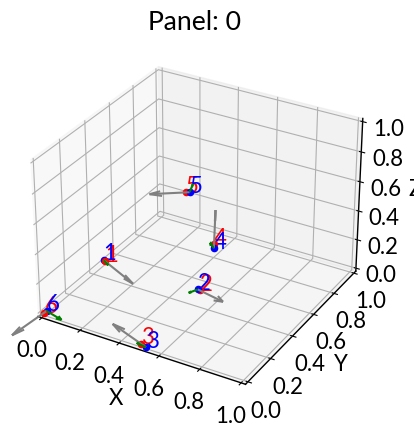

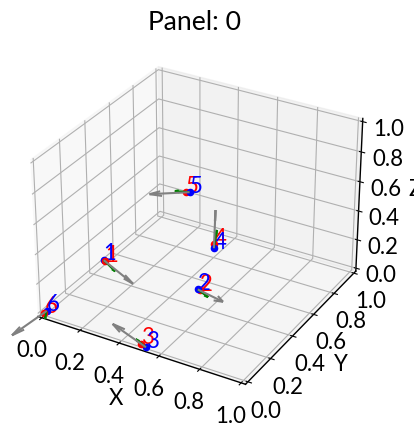

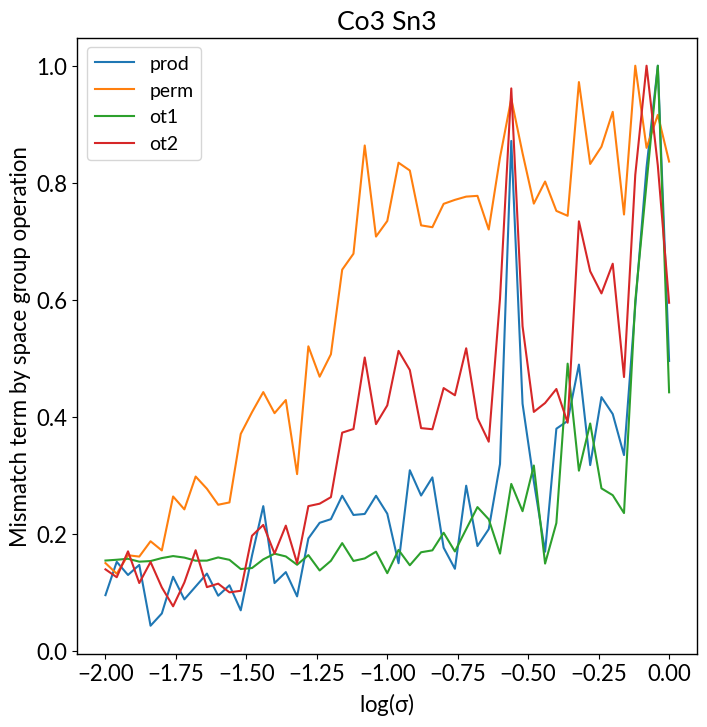

In [32]:
# with grad
# test with the diffused structures
logvars = np.linspace(-2, 0, num=51) #range(10, -5, -1)
xs = [10**l for l in logvars]
ys0, ys1, ys2, ys3 = [], [], [], []
frac0_list, grads0_list = [], []
frac1_list, grads1_list = [], []
frac2_list, grads2_list = [], []
frac3_list, grads3_list = [], []
pstruct = cosn 
frac_coords0 = pstruct.frac_coords
mt = MatTrans(pstruct)
opes = list(set(mt.spgops))
oprs = [op.rotation_matrix for op in opes]
opts = [op.translation_vector for op in opes]
oprs = [torch.tensor(opr, requires_grad=False) for opr in oprs]
natms = len(mt.pstruct.sites)
nops = len(opes)
r_max = 0.7
h = 1e-07
tol = 1e-03
grad=True
for i, l in enumerate(logvars):
    sigma = 10**l
    dstruct = diffuse_frac(pstruct, sigma=sigma)
    # vis_structure(dstruct, title=f"$log(\sigma)$={round(l, 7)}")
    # plt.show()
    # plt.close()
    frac = torch.tensor(dstruct.frac_coords)
    frac.requires_grad = grad
    frac0, frac1, frac2, frac3 = torch.tensor(dstruct.frac_coords), torch.tensor(dstruct.frac_coords), torch.tensor(dstruct.frac_coords), torch.tensor(dstruct.frac_coords)
    frac0.requires_grad, frac1.requires_grad = grad, grad
    loss0 = sgo_cum_loss(frac0, oprs, r_max)
    ys0.append(loss0)
    loss0.backward()
    grads0 = frac0.grad
    frac0_list.append(frac0.detach().numpy())
    grads0_list.append(-grads0.detach().numpy())
    loss1 = sgo_cum_loss_perm(frac1, oprs, r_max)
    ys1.append(loss1)
    loss1.backward()
    grads1 = frac1.grad
    frac1_list.append(frac1.detach().numpy())
    grads1_list.append(-grads1.detach().numpy())
    loss2 = sgo_cum_loss_ot1(frac2, oprs, r_max)
    ys2.append(loss2)
    loss2.backward()
    grads2 = frac2.grad
    frac2_list.append(frac2.detach().numpy())
    # grads2_list.append(-grads2.detach().numpy())
    loss3 = sgo_cum_loss_ot2(frac3, oprs, r_max)
    ys3.append(loss3)
    loss3.backward()
    grads3 = frac3.grad
    frac3_list.append(frac3.detach().numpy())
    # grads3_list.append(-grads3.detach().numpy())
    # plot_3d_vectors(frac_coords0, frac0.detach().numpy(), -grads0.detach().numpy())
    # plot_3d_vectors(frac_coords0, frac1.detach().numpy(), -grads1.detach().numpy())
create_animation(frac_coords0, frac0_list, grads0_list, 'figures/cosn0')
create_animation(frac_coords0, frac1_list, grads1_list, 'figures/cosn1')

fig, ax = plt.subplots(1,1,figsize=(8,8))
ys0 = [y.detach().numpy() for y in ys0]
ys1 = [y.detach().numpy() for y in ys1]
ys2 = [y.detach().numpy() for y in ys2]
ys3 = [y.detach().numpy() for y in ys3]
ax.plot(logvars, ys0/max(ys0), label='prod')
ax.plot(logvars, ys1/max(ys1), label='perm')
ax.plot(logvars, ys2/max(ys2), label='ot1')
ax.plot(logvars, ys3/max(ys3), label='ot2')
ax.legend()
ax.set_ylabel(f"Mismatch term by space group operation")
ax.set_xlabel(f"$log(\sigma)$")
ax.set_title(pstruct.formula)
# ax.set_yscale('log')
fig.patch.set_facecolor('white')
